In [51]:
import pandas as pd
import numpy as np
import json
import cv2
import os
import tensorflow as tf

In [3]:

with open(r"\Users\Royal_Tech\Documents\BIOIRC\arcade\syntax\test\annotations\test.json", "r") as f:
    data = json.load(f)


How big are the top level fields

In [4]:
print(len(data["categories"]))
print(len(data["annotations"]))
print(len(data["images"]))

26
1672
300


Insight into their structure

In [5]:
print(data["categories"])
print(data["annotations"][0])
print(data["images"][0])

[{'id': 1, 'name': '1', 'supercategory': ''}, {'id': 2, 'name': '2', 'supercategory': ''}, {'id': 3, 'name': '3', 'supercategory': ''}, {'id': 4, 'name': '4', 'supercategory': ''}, {'id': 5, 'name': '5', 'supercategory': ''}, {'id': 6, 'name': '6', 'supercategory': ''}, {'id': 7, 'name': '7', 'supercategory': ''}, {'id': 8, 'name': '8', 'supercategory': ''}, {'id': 9, 'name': '9', 'supercategory': ''}, {'id': 10, 'name': '9a', 'supercategory': ''}, {'id': 11, 'name': '10', 'supercategory': ''}, {'id': 12, 'name': '10a', 'supercategory': ''}, {'id': 13, 'name': '11', 'supercategory': ''}, {'id': 14, 'name': '12', 'supercategory': ''}, {'id': 15, 'name': '12a', 'supercategory': ''}, {'id': 16, 'name': '13', 'supercategory': ''}, {'id': 17, 'name': '14', 'supercategory': ''}, {'id': 18, 'name': '14a', 'supercategory': ''}, {'id': 19, 'name': '15', 'supercategory': ''}, {'id': 20, 'name': '16', 'supercategory': ''}, {'id': 21, 'name': '16a', 'supercategory': ''}, {'id': 22, 'name': '16b', 

In [6]:
for category in data["categories"]:
    print(category["name"])


1
2
3
4
5
6
7
8
9
9a
10
10a
11
12
12a
13
14
14a
15
16
16a
16b
16c
12b
14b
stenosis


In [7]:
name_to_color = {
    # RCA
    '1': (255, 0, 0),
    '2': (220, 20, 60),
    '3': (178, 34, 34),
    '4': (139, 0, 0),

    # Posterolateral  RCA
    '16':  (255, 99, 71),
    '16a': (255, 69, 0),
    '16b': (205, 92, 92),
    '16c': (240, 128, 128),

    # Left Main + LAD
    '5': (255, 215, 0),       # Left Main (golden yellow)
    '6': (0, 255, 0),         # LAD proximal
    '7': (34, 139, 34),       # LAD mid
    '8': (0, 128, 0),         # LAD apical

    # Diagonals
    '9':  (0, 191, 255),
    '9a': (30, 144, 255),
    '10': (70, 130, 180),
    '10a':(100, 149, 237),

    # Circumflex / Marginals
    '11': (148, 0, 211),      # Proximal circumflex
    '12': (186, 85, 211),
    '12a':(147, 112, 219),
    '12b':(138, 43, 226),
    '13': (153, 50, 204),

    # Left Posterolaterals + Posterior descending
    '14':  (255, 140, 0),
    '14a': (255, 165, 0),
    '14b': (255, 180, 100),
    '15':  (255, 215, 160),

    # Special case: stenosis
    'stenosis': (255, 255, 255)
}


In [8]:
images_df = pd.DataFrame(data["images"])
categories_df = pd.DataFrame(data["categories"])
annotations_df = pd.DataFrame(data["annotations"])

In [9]:
print(images_df.info())
print(categories_df.info())
print(annotations_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             300 non-null    int64 
 1   width          300 non-null    int64 
 2   height         300 non-null    int64 
 3   file_name      300 non-null    object
 4   license        300 non-null    int64 
 5   flickr_url     300 non-null    object
 6   coco_url       300 non-null    object
 7   date_captured  300 non-null    int64 
dtypes: int64(5), object(3)
memory usage: 18.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             26 non-null     int64 
 1   name           26 non-null     object
 2   supercategory  26 non-null     object
dtypes: int64(1), object(2)
memory usage: 756.0+ bytes
None
<class 'pandas.core.frame.DataFra

In [10]:
sample_id = 1
segmentations = annotations_df[annotations_df["image_id"]==sample_id]
categories_df["color"] = categories_df["name"].map(name_to_color)
print(segmentations)


   id  image_id  category_id  \
0   1         1           18   
1   2         1            5   
2   3         1           17   
3   4         1           25   
4   5         1           13   
5   6         1           16   

                                        segmentation    area  \
0  [[252.3, 288.21, 257.7, 289.21, 261.5, 291.81,...  1373.0   
1  [[151.59, 207.74, 153.21, 206.12, 154.99, 204....   956.0   
2  [[254.1, 259.41, 257.5, 259.41, 260.1, 260.01,...   428.0   
3  [[223.6, 393.7, 229.18, 395.39, 231.0, 396.6, ...  2270.0   
4  [[188.8, 156.5, 195.9, 156.2, 201.1, 155.6, 20...  1015.0   
5  [[244.42, 210.1, 243.1, 219.4, 243.6, 227.8, 2...  1888.0   

                             bbox  iscrowd           attributes  
0   [252.3, 288.21, 169.6, 102.8]        0  {'occluded': False}  
1   [142.74, 157.1, 49.58, 50.64]        0  {'occluded': False}  
2   [253.54, 259.41, 56.76, 65.0]        0  {'occluded': False}  
3  [218.08, 354.2, 234.82, 79.26]        0  {'occluded': False

In [11]:
masked_image = np.zeros((512,512,3))

for index, row in segmentations.iterrows():
    category_id = row["category_id"]
    segmentation_verticies = np.array(row["segmentation"][0]).reshape(-1,2)
    segmentation_label = categories_df[categories_df["id"]==category_id]["name"].iloc[0]
    color = categories_df[categories_df["id"]==category_id]["color"].iloc[0]
    bbox = row["bbox"]

    print("Label fo segmentation")
    print(categories_df[categories_df["id"]==category_id]["name"].iloc[0])
    print("List of verticies")
    print(segmentation_verticies)
    print("Border box coordinates")
    print(bbox)
    print("Chosen RGB color is")
    print(color)
    cv2.fillPoly(masked_image, pts=[segmentation_verticies.astype(np.int32)], color=color)


Label fo segmentation
14a
List of verticies
[[252.3  288.21]
 [257.7  289.21]
 [261.5  291.81]
 [264.5  293.01]
 [266.7  296.81]
 [267.7  300.81]
 [267.9  303.61]
 [266.7  306.21]
 [264.7  308.01]
 [265.5  310.61]
 [266.3  313.61]
 [261.9  317.81]
 [259.9  323.01]
 [259.5  328.41]
 [259.5  329.41]
 [260.1  336.81]
 [262.1  340.01]
 [262.1  343.61]
 [263.1  349.81]
 [264.1  353.81]
 [265.9  357.41]
 [267.1  360.21]
 [270.9  364.21]
 [272.3  365.81]
 [273.5  366.21]
 [275.3  366.61]
 [278.3  365.41]
 [282.9  365.21]
 [287.1  365.41]
 [287.5  365.61]
 [288.1  366.01]
 [289.3  366.81]
 [290.   369.4 ]
 [292.5  372.2 ]
 [295.5  373.81]
 [298.1  375.21]
 [301.1  376.01]
 [305.7  377.81]
 [308.7  379.21]
 [311.1  379.61]
 [312.9  379.61]
 [315.1  377.81]
 [316.7  375.61]
 [318.7  373.21]
 [321.5  372.21]
 [324.3  371.41]
 [328.3  370.61]
 [331.1  370.41]
 [335.1  372.61]
 [337.7  375.41]
 [338.3  379.61]
 [338.5  381.61]
 [339.5  384.41]
 [341.9  383.61]
 [342.6  379.8 ]
 [344.7  379.81]
 [34

Representations of the original image and the segmented one

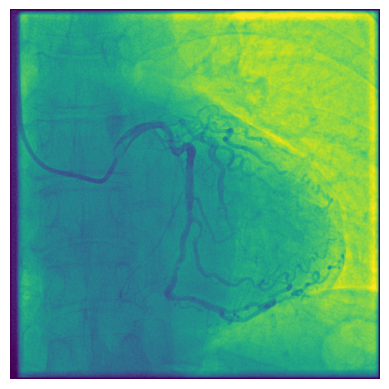

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

original_image_path = r"C:\Users\Royal_Tech\Documents\BIOIRC\arcade\syntax\test\images\1.png"
image = mpimg.imread(original_image_path)

plt.imshow(image)
plt.axis('off')
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


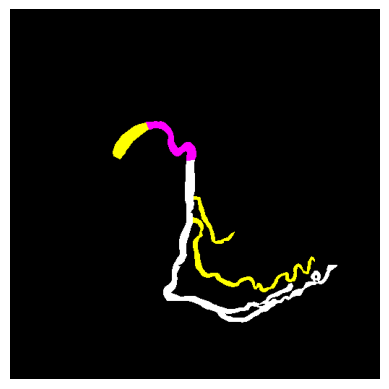

True

In [13]:
import matplotlib.pyplot as plt

plt.imshow(masked_image)

plt.axis('off')  # optional
plt.show()
cv2.imwrite("prvaSlika.png",masked_image)

In [49]:
def generate_mask(sample_id, destination_directory,annon_df,cat_df):
    segs = annon_df[annon_df["image_id"]==sample_id]
    masked_image = np.zeros((512, 512, 3), dtype=np.uint8)

    for _, row in segs.iterrows():
        category_id = row["category_id"]
        segmentation_verticies = np.array(row["segmentation"][0]).reshape(-1,2)
        color = cat_df[cat_df["id"]==category_id]["color"].iloc[0]
        cv2.fillPoly(masked_image, pts=[segmentation_verticies.astype(np.int32)], color=color)
    
    output_path = os.path.join(destination_directory, str(sample_id) + ".png")
    cv2.imwrite(output_path,masked_image)


In [50]:
syntax_folder = r"C:\Users\Royal_Tech\Documents\BIOIRC\arcade\syntax"

with open(r"C:\Users\Royal_Tech\Documents\BIOIRC\arcade\syntax\train\annotations\train.json","r") as f:
        train_data = json.load(f)

with open(r"C:\Users\Royal_Tech\Documents\BIOIRC\arcade\syntax\test\annotations\test.json","r") as f:
        test_data = json.load(f)


with open(r"C:\Users\Royal_Tech\Documents\BIOIRC\arcade\syntax\val\annotations\val.json","r") as f:
        validate_data = json.load(f)


for subfolder in os.listdir(syntax_folder):
    subfolder_path = os.path.join(syntax_folder, subfolder)  
    dest_dir = os.path.join(syntax_folder, subfolder_path, "multi_class_mask")
    images_dir = os.path.join(subfolder_path, "images")
    annotation_filename = f"{subfolder}.json"
    annotationJSON = os.path.join(subfolder_path,"annotations",annotation_filename) # Bug when using open additional backslashes added between folders pls help me
    os.makedirs(dest_dir, exist_ok=True)
    
    if(subfolder=="train"):
        data = train_data
    elif(subfolder=="test"):
        data = test_data
    else:
        data = validate_data

    cat_df = pd.DataFrame(data["categories"])
    cat_df["color"] = cat_df["name"].map(name_to_color)
    annon_df = pd.DataFrame(data["annotations"])    
    
    for filename in os.listdir(images_dir):
        image_id = int(os.path.splitext(filename)[0])
        generate_mask(image_id,dest_dir,annon_df, cat_df)

In [57]:
train_x = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\Royal_Tech\Documents\BIOIRC\arcade\stenosis\train\images",
    labels=None,
    class_names=None,
    image_size=(512,512),
    shuffle=False,
    batch_size=32
)

test_x = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\Royal_Tech\Documents\BIOIRC\arcade\stenosis\test\images",
    labels=None,
    class_names=None,
    image_size=(512,512),
    shuffle=False,
    batch_size=32
)

validate_x = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\Royal_Tech\Documents\BIOIRC\arcade\stenosis\val\images",
    labels=None,
    class_names=None,
    image_size=(512,512),
    shuffle=False,
    batch_size=32
)

Found 1000 files.
Found 300 files.
Found 200 files.


In [62]:
print(train_x.take(1))

<_TakeDataset element_spec=TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None)>


Defining the U-Net model    

In [68]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, SeparableConv2D, Dropout
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Activation, MaxPooling2D, concatenate


def conv_block(inputs=None, n_filters=64, batch_norm=False, dropout_prob=0):
    conv1 = SeparableConv2D(n_filters,3,padding="same")(inputs)
    if batch_norm:
        conv1 = BatchNormalization(axis=-1)(conv1)
    conv1 = LeakyReLU(alpha=0.2)(conv1)

    conv2 = SeparableConv2D(n_filters,3,padding="same")(conv1)
    if batch_norm:
        conv2 = BatchNormalization(axis=-1)(conv2)
    conv2 = LeakyReLU(alpha=0.2)(conv2)


    return conv2


def encoder_block(inputs=None, n_filters=64, batch_norm=False, dropout_prob=0):
    skip_connection = conv_block(inputs, n_filters, batch_norm, dropout_prob)
    next_layer = MaxPooling2D((2,2))(skip_connection)

    return next_layer, skip_connection

def decoder_block(expansive_input, skip_connection, n_filters, batch_norm=False, dropout_prob=0):
    up = Conv2DTranspose(n_filters, 3, strides=2, padding="same")(expansive_input)
    merge = concatenate([up, skip_connection], axis=-1)
    conv = conv_block(merge, n_filters, batch_norm, dropout_prob)
    return conv

def standard_u_net(input_size=(512,512,3), n_filters=64, n_classes=5, batch_norm=True, dropouts=np.zeros(10)):

    inputs = Input(input_size)

    encoder_block1 = encoder_block(inputs,n_filters,batch_norm,dropout_prob=dropouts[0])
    encoder_block2 = encoder_block(encoder_block1[0],n_filters*2,batch_norm,dropout_prob=dropouts[1])
    encoder_block3 = encoder_block(encoder_block2[0],n_filters*4,batch_norm,dropout_prob=dropouts[2])
    encoder_block4 = encoder_block(encoder_block3[0],n_filters*8,batch_norm,dropout_prob=dropouts[3])
    encoder_block5 = encoder_block(encoder_block4[0],n_filters*16,batch_norm,dropout_prob=dropouts[4])

    bridge = conv_block(encoder_block5[0], n_filters*32, batch_norm, dropout_prob=dropouts[5])

    decoder_block1 = decoder_block(bridge,encoder_block5[1],n_filters*16,batch_norm,dropout_prob=dropouts[0])
    decoder_block2 = decoder_block(decoder_block1,encoder_block4[1],n_filters*8,batch_norm,dropout_prob=dropouts[1])
    decoder_block3 = decoder_block(decoder_block2,encoder_block3[1],n_filters*4,batch_norm,dropout_prob=dropouts[2])
    decoder_block4 = decoder_block(decoder_block3,encoder_block2[1],n_filters*2,batch_norm,dropout_prob=dropouts[3])
    decoder_block5 = decoder_block(decoder_block4,encoder_block1[1],n_filters,batch_norm,dropout_prob=dropouts[4])

    conv10 = Conv2D(n_classes, 1, padding="same")(decoder_block5)
    output = Activation("softmax")(conv10)

    model = tf.keras.Model(inputs=inputs, outputs=output, name="Unet")

    return model

In [69]:
model = standard_u_net()
model.summary()

c:\Users\Royal_Tech\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Unet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_24 │ (None, 512, 512,  │        283 │ input_layer_2[0]… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_24      │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_25 │ (None, 512, 512,  │      4,736 │ leaky_re_lu_24[0… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_25      │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 256, 256,  │          0 │ leaky_re_lu_25[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_26 │ (None, 256, 256,  │      8,896 │ max_pooling2d_10… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_26      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_27 │ (None, 256, 256,  │     17,664 │ leaky_re_lu_26[0… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_27      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 128, 128,  │          0 │ leaky_re_lu_27[0… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_28 │ (None, 128, 128,  │     34,176 │ max_pooling2d_11… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │      1,024 │ separable_conv2d

 Total params: 37,886,368 (144.53 MB)

 Trainable params: 37,862,304 (144.43 MB)

 Non-trainable params: 24,064 (94.00 KB)

In [ ]:
model.fit(
    train_x,
    validation_data=(validate_x),
    epochs=11
)